# Курсовая работа Волошин Александра

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
data = pd.read_csv('Kurs_project_task/train.csv')

In [3]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### Причесываем данные до состояния пригодного к моделированию

#### Ищем ситуации, когда жилая площадь больше общей

In [5]:
data.loc[data['Square'] < data['LifeSquare']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284


In [6]:
data.loc[data['Square'] < data['LifeSquare']].count()

Id               482
DistrictId       482
Rooms            482
Square           482
LifeSquare       482
KitchenSquare    482
Floor            482
HouseFloor       482
HouseYear        482
Ecology_1        482
Ecology_2        482
Ecology_3        482
Social_1         482
Social_2         482
Social_3         482
Healthcare_1     169
Helthcare_2      482
Shops_1          482
Shops_2          482
Price            482
dtype: int64

Как мы видим таких значений достаточно много и разница между Square и LifeSquare в большинстве случаев минимальна. Из чего я сделал вывод, что данные строки были просто перепутаны местами при составлении сводной таблицы

In [7]:
def replace_square(df):
    df.loc[df['Square'] < df['LifeSquare'], 'Square_LifeSquare'] = df['Square']
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare_Square'] = df['LifeSquare']
    df.loc[df['Square_LifeSquare'] < df['LifeSquare_Square'],'Square'] = df['LifeSquare_Square']
    df.loc[df['Square_LifeSquare'] < df['LifeSquare_Square'],'LifeSquare'] = df['Square_LifeSquare']
    df = df.drop(['LifeSquare_Square', 'Square_LifeSquare'], axis = 1)
    return df

In [8]:
data = replace_square(data)

#### Приводим к числовому виду столбцы с категорийными данными

In [9]:
data['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [10]:
data['Ecology_3'].unique()

array(['B', 'A'], dtype=object)

In [11]:
data['Shops_2'].unique()

array(['B', 'A'], dtype=object)

In [12]:
def cat_replace(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'A').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'A').astype(int)

In [13]:
cat_replace(data)

#### Ищем стуации, когда общая площадь аномально низкая

In [14]:
data.loc[data['Square'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,0,0,4,915,0,NaN,0,0,0,107604.269441
1608,10202,6,1.0,4.604943,2.596351,1.0,3,25.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0,137597.601458
3413,9487,5,1.0,5.549458,5.129222,1.0,1,1.0,1977,0.150818,0,0,16,3433,4,2643.0,4,5,0,369472.403061
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,0,0,2,469,0,NaN,0,0,0,126596.941798
4900,4504,27,3.0,5.610772,4.390331,1.0,8,19.0,2016,0.211401,0,0,9,1892,0,NaN,0,1,0,161379.067034
6392,14786,1,1.0,4.525736,1.136859,1.0,3,1.0,1977,0.007122,0,0,1,264,0,NaN,0,1,0,181434.825589
8283,15744,34,1.0,2.642219,1.988943,1.0,21,4.0,1977,0.069753,0,0,53,13670,4,NaN,1,11,0,458378.777006
9294,6782,45,1.0,5.257278,2.954309,1.0,3,1.0,1977,0.195781,0,0,23,5212,6,NaN,3,2,0,438005.182323
9613,7657,38,1.0,4.618547,4.502784,1.0,28,1.0,1977,0.060753,0,0,15,2787,2,520.0,0,7,0,483283.488083


Аномально низкие значения не только у Square, но и LifeSquare. Что выглядит, как ошибка разряда. Поэтому я решил домножить данные значения на 10. В таком виде данные становятся похожие на правду

In [15]:
def low_square_lifesquare(df):
    df.loc[df['Square'] < 10, 'LifeSquare'] = df['LifeSquare']*10
    df.loc[df['Square'] < 10, 'Square'] = df['Square']*10    

In [16]:
low_square_lifesquare(data)

#### Решаем проблему с null в столбце LifeSquare

В данной ситуации встал вопрос, как наиболее корректно заполнить столбец с жилой площадью. При просмотре даных обратил внимание, что большое число строк с пропущенной жилой площадью имеют кухню с 0 или 1 площади

In [17]:
data.loc[(data['LifeSquare'].isnull()) & (data['KitchenSquare'] == 0)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,0,0,30,5285,0,645.0,6,6,0,571069.052600
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,0,0,0,168,0,NaN,0,0,0,229778.057902
65,11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,114063.092041
70,10362,27,2.0,79.227049,NaN,0.0,9,0.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,167023.973143


In [18]:
data.loc[(data['LifeSquare'].notnull()) & (data['KitchenSquare'] == 0)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,0,0,2,629,1,NaN,0,0,1,337299.867936
42,9833,1,2.0,56.494318,54.723569,0.0,9,17.0,1977,0.007122,0,0,1,264,0,NaN,0,1,0,196078.907289
44,10521,38,3.0,106.340403,104.211396,0.0,20,0.0,2017,0.060753,0,0,15,2787,2,520.0,0,7,0,435462.048070
52,2301,1,2.0,65.224603,61.400054,0.0,17,22.0,2016,0.007122,0,0,1,264,0,NaN,0,1,0,199215.452229


In [19]:
data.loc[data['LifeSquare'].isnull()].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,0,0,1,264,0,NaN,0,1,0,229102.795999
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,0,0,9,1892,0,NaN,0,1,0,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,0,0,30,5285,0,645.0,6,6,0,571069.052600
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,244145.827069


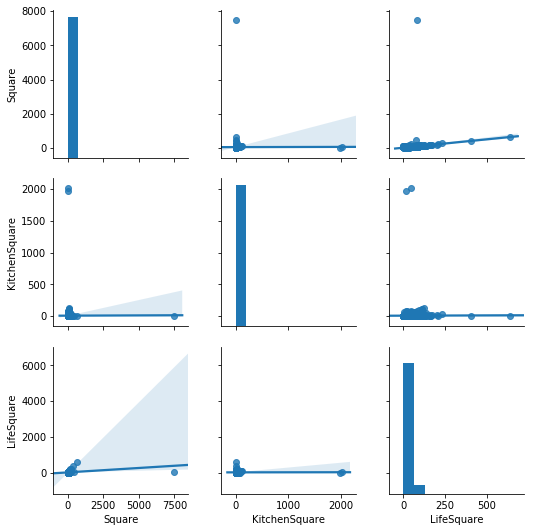

In [20]:
sns.pairplot(data.loc[data['LifeSquare'].notnull(), ['Square', 'KitchenSquare', 'LifeSquare']], 
            kind='reg', 
            diag_kind='hist')

График подтверждает предположение. Изначально я подумал, что это ошибка и мы имеем также битые данные в площади кухни, госты для квартир это подтверждают

Text(0, 0.5, 'Square')

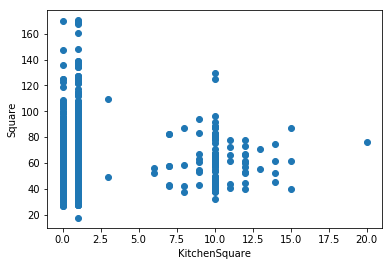

In [21]:
plt.scatter(data.loc[(data['LifeSquare'].isnull()) & (data['KitchenSquare'] < 25), 'KitchenSquare'], 
            data.loc[(data['LifeSquare'].isnull()) & (data['Square'] < 200), 'Square'])

plt.xlabel('KitchenSquare')
plt.ylabel('Square')

Но достаточно большое число таких квартир вызвало предположение, что это просто не квартиры, а аппартаменты для которых гостов с требованиями по площади кухни нет. Ее там в принципе может не быть и это нормально. При попытке посмотреть, какая связь между площадью кухни и общей площадью на тех данных, где жилая указана. Обнаружил битые цифры по общей площади и площади кухни

Text(0, 0.5, 'Square')

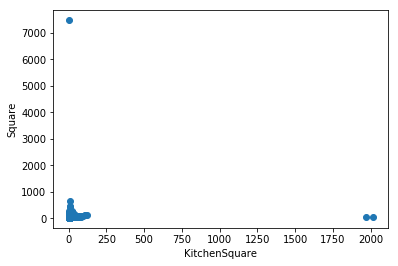

In [22]:
plt.scatter(data.loc[(data['LifeSquare'].notnull()), 'KitchenSquare'], 
            data.loc[(data['LifeSquare'].notnull()), 'Square'])

plt.xlabel('KitchenSquare')
plt.ylabel('Square')

In [23]:
data.loc[data['KitchenSquare'] > data['LifeSquare']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,0,0,5,1564,0,540.0,0,0,0,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,0,0,2,629,1,NaN,0,0,1,108337.484207
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,0,0,2,469,0,NaN,0,0,0,189244.249909
1800,13113,27,1.0,37.805231,2.228592,11.0,6,0.0,2015,0.017647,0,0,2,469,0,NaN,0,0,0,137402.092529


Править площадь кухни до правки цифр жилой площади считаю преждевременным, поэтому такие записи будут обработаны в дальнейшем

Text(0, 0.5, 'Square')

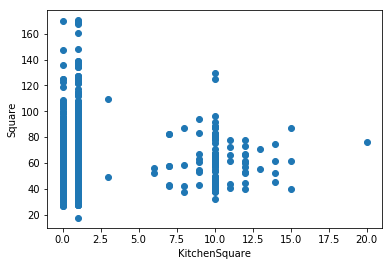

In [24]:
plt.scatter(data.loc[(data['LifeSquare'].isnull()) & (data['KitchenSquare'] < 25), 'KitchenSquare'], 
            data.loc[(data['LifeSquare'].isnull()) & (data['Square'] < 200), 'Square'])

plt.xlabel('KitchenSquare')
plt.ylabel('Square')

График выше на данных где жилая заполнена подтверждает мое предположение. Также для данных жилых помещений характерна крайне высокая жилая площадь, близкая к общей. Исходя из этого при заполнении жилой площади для схожих квартир я решил опираться в том числе на площадь кухни.
Для подсчета коэффицента, который позволит вычислить жилую площадь я брал только те квартиры в которых жилая составляет более половины общей. Квартиры в которых данные цифры обратны в нашем мире также являются аномальными, поэтому для данных квартир я также производил корректировку цифр

Правка данных для квартир с 0 кухней

In [25]:
def mean_sl_k0(df):
    mean_square_k0 = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] == 0) & 
    (df['LifeSquare'] > df['Square'] / 2), 'Square'].mean()
    mean_lifesquare_k0 = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] == 0) & 
    (df['LifeSquare'] > df['Square'] / 2), 'LifeSquare'].mean()
    mean_sl_k0 = mean_lifesquare_k0 / mean_square_k0
    df.loc[
        ((df['LifeSquare'].isnull()) | (df['LifeSquare'] < df['Square'] / 2)) & 
        (df['KitchenSquare'] == 0), 'LifeSquare'] = df['Square']*mean_sl_k0    

In [26]:
data.loc[(data['LifeSquare'].isnull()) & (data['KitchenSquare'] == 0)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,0,0,30,5285,0,645.0,6,6,0,571069.052600
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,0,0,0,168,0,NaN,0,0,0,229778.057902
65,11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,114063.092041
70,10362,27,2.0,79.227049,NaN,0.0,9,0.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,167023.973143


In [27]:
mean_sl_k0(data)

In [28]:
data.loc[(data['LifeSquare'].notnull()) & (data['KitchenSquare'] == 1)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
12,6452,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,0,0,74,19083,2,NaN,5,15,0,229220.372609
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,140647.565937
28,8054,23,1.0,43.967759,42.530043,1.0,3,9.0,2014,0.034656,0,0,0,168,0,NaN,0,0,0,95338.198549
32,13253,27,2.0,63.679116,37.275775,1.0,9,15.0,1977,0.017647,0,0,2,469,0,NaN,0,0,0,178721.706337
74,4014,6,2.0,63.184422,61.142894,1.0,17,17.0,2016,0.243205,0,0,5,1564,0,540.0,0,0,0,190762.981550


Правка данных для квартир с 1м кухни

In [29]:
def mean_sl_k1(df):
    mean_square_k1 = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] == 1), 'Square'].mean()
    mean_lifesquare_k1 = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] == 1), 'LifeSquare'].mean()
    mean_sl_k1 = mean_lifesquare_k1 / mean_square_k1
    df.loc[
        ((df['LifeSquare'].isnull()) | (df['LifeSquare'] < df['Square'] / 2)) & 
        (df['KitchenSquare'] == 1), 'LifeSquare'] = df['Square']*mean_sl_k1

In [30]:
mean_sl_k1(data)

In [31]:
data.loc[(data['LifeSquare'].isnull()) & (data['KitchenSquare'] > 1)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
152,14141,23,2.0,57.699619,NaN,10.0,2,1.0,1977,0.034656,0,0,0,168,0,NaN,0,0,0,114168.532703
334,15979,27,1.0,47.426349,NaN,10.0,9,1.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1,148330.648623
416,10325,1,1.0,37.662346,NaN,10.0,8,17.0,2018,0.007122,0,0,1,264,0,NaN,0,1,0,119627.821578
448,8119,27,3.0,56.579350,NaN,12.0,24,27.0,2014,0.072158,0,0,2,629,1,NaN,0,0,1,205998.692174
461,16538,17,3.0,124.601250,NaN,10.0,18,20.0,2016,0.093443,0,0,23,4635,5,3300.0,2,4,0,497573.388939


Правка данных для квартир с более 1м размером кухни, коих остается меньшинство

In [32]:
def mean_sl_k(df):
    mean_square_k = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] > 1), 'Square'].mean()
    mean_lifesquare_k = df.loc[
    (df['LifeSquare'].notnull()) & 
    (df['KitchenSquare'] > 1), 'LifeSquare'].mean()
    mean_sl_k = mean_lifesquare_k / mean_square_k
    df.loc[
        ((df['LifeSquare'].isnull()) | (df['LifeSquare'] < df['Square'] / 2)) & 
        (df['KitchenSquare'] > 1), 'LifeSquare'] = df['Square']*mean_sl_k

In [33]:
mean_sl_k(data)

Проверил наличие квартир с низкой жилой площадью. Такая квартира 1, но общие данные похожи на правду, поэтому никаких действий не производил

In [34]:
data.loc[data['LifeSquare'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7767,6927,21,1.0,16.117154,8.822988,0.0,2,5.0,1965,0.194489,0,0,47,8004,3,125.0,3,5,0,79913.267856


Вернемся к аномальным кухням

In [35]:
data.loc[data['KitchenSquare'] > data['LifeSquare']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,0,0,5,1564,0,540.0,0,0,0,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,0,0,2,629,1,NaN,0,0,1,108337.484207
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,0,0,2,469,0,NaN,0,0,0,189244.249909
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,0,0,14,3369,24,4129.0,0,3,0,261125.669724


In [36]:
data.loc[data['KitchenSquare'] > data['LifeSquare']].count()

Id               16
DistrictId       16
Rooms            16
Square           16
LifeSquare       16
KitchenSquare    16
Floor            16
HouseFloor       16
HouseYear        16
Ecology_1        16
Ecology_2        16
Ecology_3        16
Social_1         16
Social_2         16
Social_3         16
Healthcare_1      5
Helthcare_2      16
Shops_1          16
Shops_2          16
Price            16
dtype: int64

Данных записей немного и для них характерна площадь кухни близкая к общей. Из чего я могу сделать вывод, что либо это кулинария, либо кто-то просто общую площадь вписал в площадь кухни

In [37]:
def clean_KitchenSquare(df):
    df.loc[df['KitchenSquare'] > df['LifeSquare'], 'KitchenSquare'] = -999

In [38]:
clean_KitchenSquare(data)

Далее надо было что-то сделать с пропущенными значениями в Healthcare_1. Для их заполнения я использовал устредненные данные по району, но оказалось, что хватает районов где просто Null. С другой стороны это не редкость, когда в районе медицинских учреждений нет и жители ездят в соседний, поэтому посчитал достаточно корректным в таких районах поставить 0

In [39]:
data.loc[data['Healthcare_1'].notnull()].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,0,0,35,7715,4,990.0,0,6,0,215898.447742


In [40]:
def null_healthcare_1(df):
    mean_healthcare_1 = df.groupby('DistrictId', as_index=False)[['Healthcare_1']].mean().\
    sort_values('Healthcare_1', ascending=False).rename(columns={'Healthcare_1':'mean_healthcare_1'})
    df = pd.merge(df, mean_healthcare_1, on='DistrictId', how='left')
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['mean_healthcare_1']
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0
    df = df.drop('mean_healthcare_1', axis = 1)
    return df

In [41]:
data = null_healthcare_1(data)

Для аномальных годов постройки дома цифры заменил на усредненные

In [42]:
data.loc[data['HouseYear'] > 2020].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,0,0,30,6141,10,262.0,3,6,0,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,0,0,25,4756,16,2857.0,5,8,0,243028.603096


In [43]:
def clean_year(df):
    mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [44]:
clean_year(data)

### Добавляем строки, которые улучшают результаты моделирования

Добавляем среднюю цену

In [45]:
data.groupby('DistrictId', as_index=False)[['Price']].mean().sort_values('Price', ascending=False).head()

,DistrictId,Price
195,195,482791.138606
190,190,471966.746348
181,181,450654.779595
182,182,441284.916612
197,199,432546.129741


In [46]:
mean_price = data.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().\
    rename(columns={'Price':'mean_price'})
mean_price.head()

,DistrictId,Rooms,mean_price
0,0,1.0,141262.601991
1,0,2.0,197998.146681
2,0,3.0,304170.518823
3,1,1.0,147454.605358
4,1,2.0,198777.278269


In [47]:
mean_price2 = data.groupby('Rooms', as_index=False)[['Price']].mean().\
    rename(columns={'Price':'mean_price2'})
mean_price2.head()

,Rooms,mean_price2
0,0.0,200435.886261
1,1.0,159850.800729
2,2.0,215256.306416
3,3.0,289337.962452
4,4.0,383251.100956


In [48]:
mean_price3 = data.groupby(['DistrictId', 'HouseYear'], as_index=False)[['Price']].mean().\
    rename(columns={'Price':'mean_price3'})
mean_price3.head()

,DistrictId,HouseYear,mean_price3
0,0,1959.0,221660.251771
1,0,1960.0,339228.823764
2,0,1961.0,115835.592141
3,0,1962.0,139395.378454
4,0,1963.0,142675.434583


In [49]:
mean_price_all = data['Price'].mean()
mean_price_all

214138.85739873844

In [50]:
def add_mean_price(df, mean_price=mean_price, mean_price2=mean_price2):
    global mean_price_all
    df = pd.merge(df, mean_price3, on=['DistrictId', 'HouseYear'], how='left')
    df['mean_price3'] = df['mean_price3'].fillna(mean_price_all)
    df = pd.merge(df, mean_price2, on='Rooms', how='left')
    df['mean_price2'] = df['mean_price2'].fillna(df['mean_price3'])
    df = pd.merge(df, mean_price, on=['DistrictId', 'Rooms'], how='left')
    df['mean_price'] = df['mean_price'].fillna(df['mean_price2'])
    df = df.drop(['mean_price2','mean_price3'], axis=1)
    return df

In [51]:
data = add_mean_price(data)

In [52]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,mean_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,0,0,33,7976,5,0.0,0,11,0,184966.930730,213160.076297
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063,303643.563728
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524,259938.729121
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217,172368.882269
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644,155748.415754


Добавляем среднюю цену за 1м

In [53]:
data['price_m2_s'] = data['Price'] / data['Square']
data['price_m2_ls'] = data['Price'] / data['LifeSquare']

In [54]:
price_m2_s = data.groupby(['DistrictId'], as_index=False)[['price_m2_s']].mean()
price_m2_s.head()

,DistrictId,price_m2_s
0,0,3710.401014
1,1,3202.403882
2,2,4557.469606
3,3,3783.790553
4,4,5247.142313


In [55]:
price_m2_ls = data.groupby(['DistrictId'], as_index=False)[['price_m2_ls']].mean()
price_m2_ls.head()

,DistrictId,price_m2_ls
0,0,5826.128520
1,1,4402.636361
2,2,7355.283539
3,3,6180.626805
4,4,7670.262855


In [56]:
data = data.drop(['price_m2_s','price_m2_ls'], axis=1)

In [57]:
def add_price_m2(df, price_m2_s=price_m2_s, price_m2_ls=price_m2_ls):
    df = pd.merge(df, price_m2_s, on=['DistrictId'], how='left')
    df = pd.merge(df, price_m2_ls, on=['DistrictId'], how='left')
    return df

In [58]:
data = add_price_m2(data)

In [59]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,mean_price,price_m2_s,price_m2_ls
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,0,0,33,7976,5,0.0,0,11,0,184966.930730,213160.076297,4384.628620,6912.735092
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063,303643.563728,4293.480295,7087.064438
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524,259938.729121,4829.484247,7269.088070
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217,172368.882269,3017.257551,4400.591745
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644,155748.415754,3938.329635,6320.917788


### Разбиваем данные на train и valid

In [60]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

Указываем признаки

In [61]:
feats = [
'DistrictId',
'Rooms',
'Square',
'LifeSquare',
'KitchenSquare',
'Floor',
'HouseFloor',
'HouseYear',
'Ecology_1',
'Ecology_2',
'Ecology_3',
'Social_1',
'Social_2',
'Social_3',
'Healthcare_1',
'Helthcare_2',
'Shops_1',
'Shops_2',
'mean_price',
'price_m2_s',
'price_m2_ls'
]

### Random Forest

In [62]:
def evaluate_model(model, train, valid, metric, feats, target, max_depth, max_features, n_estimators):
    dtr = model(max_depth=max_depth, max_features=max_features, n_estimators=n_estimators)
    dtr.fit(train.loc[:, feats], train[target])
    y_pred_train = dtr.predict(train.loc[:, feats])
    y_pred_valid = dtr.predict(valid.loc[:, feats])
    metric_train = metric(train[target], y_pred_train)
    metric_valid = metric(valid[target], y_pred_valid)
    return metric_train, metric_valid

In [63]:
parameters = [{'n_estimators': [20, 30, 40], 
               'max_features': np.arange(5, 9),
               'max_depth': np.arange(10, 15)}]

In [64]:
clf = GridSearchCV(estimator=RFR(random_state=42), 
                   param_grid=parameters,
                   cv=5)

In [65]:
clf.fit(train.loc[:, feats], train['Price'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [20, 30, 40], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([10, 11, 12, 13, 14])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
clf.best_params_

{'max_depth': 13, 'max_features': 8, 'n_estimators': 40}

In [67]:
evaluate_model(model=RFR, train=train, valid=valid, metric=r2, feats=feats, target='Price', 
               max_depth=13, max_features=8, n_estimators=40)

(0.9368665061953132, 0.7521333786635942)

In [68]:
model = RFR(max_depth=13, max_features=8, n_estimators=40, random_state=42)

In [69]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

### Test

In [70]:
test = pd.read_csv('Kurs_project_task/test.csv')

In [71]:
cat_replace(test)

In [72]:
test = replace_square(test)

In [73]:
low_square_lifesquare(test)

In [74]:
mean_sl_k0(test)

In [75]:
mean_sl_k1(test)

In [76]:
mean_sl_k(test)

In [77]:
clean_KitchenSquare(test)

In [78]:
test = null_healthcare_1(test)

In [79]:
clean_year(test)

In [80]:
test = add_mean_price(test)

In [81]:
test = add_price_m2(test)

В тестовых данных нашлись районы, которые отсутствуют в базовых. Считать стоимость 1м, используя для группировки комнаты посчитал некорректным, потому что это даст крайне приблизительные значения, поэтому заменил Null на заведомо неверные

In [82]:
test.loc[test['price_m2_s'].isnull(), 'price_m2_s'] = -999

In [83]:
test.loc[test['price_m2_ls'].isnull(), 'price_m2_ls'] = -999

In [84]:
test['Price'] = model.predict(test.loc[:, feats])

In [85]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_price,price_m2_s,price_m2_ls,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972.0,0.310199,0,0,11,2748,1,972.865854,0,0,0,172368.882269,3017.257551,4400.591745,164116.602858
1,15856,74,2.0,69.263183,50.007602,1.0,6,1.0,1977.0,0.075779,0,0,6,1437,3,910.000000,0,2,0,236250.931918,3344.694536,4617.071190,232595.842530
2,5480,190,1.0,15.948246,13.597819,12.0,2,5.0,1909.0,0.000000,0,0,30,7538,87,4702.000000,5,5,0,159850.800729,7919.443196,12126.363261,170351.515167
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007.0,0.101872,0,0,23,4583,3,254.086957,3,3,0,206507.966738,4116.345095,6840.928655,298655.677379
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017.0,0.072158,0,0,2,629,1,0.000000,0,0,1,122710.743033,2754.169584,3799.737708,143353.752589


In [86]:
test.loc[:, ['Id', 'Price']].to_csv('AVoloshin_predictions.csv', index=None)